Convert igram dates to day of year and see if the time series (one point at a time) have any yearly/seasonal trends that we can later remove. 

In [1]:
# import stuff
import os,sys
import glob
# import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
# from datetime import timedelta
# from dateutil import parser
import numpy as np
import matplotlib.pyplot as plt
# import matplotlib.patches as mpatches
# from matplotlib.patches import Rectangle
%matplotlib  widget

Read in unfiltered, unwrapped igrams. Can take a few minutes.

In [2]:
# igramsDir is where the cropped, unwrapped igrams are 
igramsDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/cropped_northern_shore_LS_for_unwrapping/unfilt_unwrapped/'
# this one is to pick out the dates 
datesDir = '/data/ocp4/LagunaSalada/cropped_9000_1800_18000_3600/'
# shape of unwrapped igrams
dx = 3000
dy = 750
# load in dates, make sure they are in order
dates = [os.path.basename(x) for x in glob.glob(datesDir+"SLC_vh/2*")]; dates = sorted(dates)
nd = len(dates); numIgrams = nd-1
# set the driver first, only do once.
driver=gdal.GetDriverByName('ISCE')
unwr_full_res = np.ndarray((numIgrams,dy,dx),dtype='float')
# loop through the dates 
for i in range(numIgrams): # numIgrams if doing all of them at once
    date1=dates[i]
    date2=dates[i+1]
    igramFile = igramsDir+date1+'_'+date2+'_unfilt.unw'
    ds = gdal.Open(igramFile,gdal.GA_ReadOnly)
    unwr_full_res[i] = ds.GetRasterBand(1).ReadAsArray(0,0,dx,dy)
print('unfiltered unwrapped igrams loaded.')

unfiltered unwrapped igrams loaded.


Reference all igrams to the reference box.

In [3]:
# correct all igrams so there's a zero/stationary point 
# (choosing that we assume no deformation across entire image, reference to the average value )
# initialize an array for corrected igrams 
unwr_full_res_cor_2 = np.ndarray(np.shape(unwr_full_res),dtype='float') # this is two reference to a smaller region and compare 
for i in range(numIgrams):
    # remove the average phase from small reference region at foot of mountains   
    unwr_full_res_cor_2[i] = unwr_full_res[i]-np.mean(unwr_full_res[i,150:180,800:900])
print('igrams corrected by subtracting avg value over small reference region in mountains.')

igrams corrected by subtracting avg value over small reference region in mountains.


Define a function that converts datetime object to float/decimal year.

In [4]:
# Need this function to convert datetime objects to decimal years. Got this off of stackexchange. 
def datetime2year(dt): 
    year_part = dt - datetime(year=dt.year, month=1, day=1)
    year_length = (
        datetime(year=dt.year + 1, month=1, day=1)
        - datetime(year=dt.year, month=1, day=1)
    )
    return dt.year + year_part / year_length

Pull out SLC dates, igram dates.

In [5]:
# dates is a list of strings, convert strings to datetime objects 
slc_dates=[]
for i in range(0,len(dates)):
    slc_dates.append(datetime.strptime(str(dates[i]).replace('\n',''), '%Y%m%d'))
# convert to floats 
slc_dates_floats = np.ndarray((len(slc_dates),1),dtype='float')
for i in range(len(slc_dates)):
    slc_dates_floats[i] = datetime2year(slc_dates[i]) # now an array of floats in years
# take numIgrams and pull out the igram_dates, corresponding to the first day of each igram
igram_dates = slc_dates[1::] # using the second SLC date per Rowena's suggestion
igram_dates_floats = slc_dates_floats[1::]
print('slc_dates: '+str(np.shape(slc_dates)))
print('igram_dates: '+str(np.shape(igram_dates)))
print('^datetime objects now')

slc_dates: (211,)
igram_dates: (210,)
^datetime objects now


Read in precip data so it can be plotted as vertical dashed lines on time series

In [6]:
# Read in 2day precipitation data and pick out rain dates
precip = np.loadtxt('/data/ocp4/LagunaSalada/3_precip/precip_2days.txt', dtype='float')
print('i \tdate \t\t       precip > 0.0cm')
rain_dates = []
rain_indices = []
for i in np.arange(len(precip)): 
    if precip[i] > 0.0:
        print(str(i)+'\t'+str(slc_dates[i])+'    '+str(precip[i])+' cm')
        rain_dates.append(slc_dates[i])
        rain_indices.append(i-1)
rain_indices = rain_indices[1::]
print(rain_indices)

i 	date 		       precip > 0.0cm
0	2017-05-10 00:00:00    0.33020000000000005 cm
47	2018-12-07 00:00:00    5.0546 cm
55	2019-03-13 00:00:00    0.0762 cm
59	2019-05-12 00:00:00    0.10160000000000001 cm
74	2019-09-27 00:00:00    1.4478 cm
83	2019-11-20 00:00:00    2.286 cm
86	2019-12-08 00:00:00    0.254 cm
97	2020-02-12 00:00:00    1.1684 cm
102	2020-03-13 00:00:00    0.40640000000000004 cm
103	2020-03-19 00:00:00    0.254 cm
107	2020-04-12 00:00:00    0.9906 cm
154	2021-01-25 00:00:00    0.0762 cm
186	2021-08-11 00:00:00    0.381 cm
[46, 54, 58, 73, 82, 85, 96, 101, 102, 106, 153, 185]


FOR A SINGLE POINT/PIXEL: <br>
Extract data from each year into it's own variable and convert dates to day of year.

In [7]:
# convert float years of igrams to day of year 
#print(igram_dates_floats[0:18])     # 2017
#print(igram_dates_floats[18:49])    # 2018
#print(igram_dates_floats[49:89])    # 2019
#print(igram_dates_floats[89:149])   # 2020
#print(igram_dates_floats[149:209])  # 2021
dates_2017 = igram_dates_floats[0:18]
dates_2018 = igram_dates_floats[18:49]
dates_2019 = igram_dates_floats[49:89]
dates_2020 = igram_dates_floats[89:149]
dates_2021 = igram_dates_floats[149:209]
# convert dates_year to day of year 
doy_2017 = ((dates_2017-2017.0)*365.25).reshape((len(dates_2017),))
doy_2018 = ((dates_2018-2018.0)*365.25).reshape((len(dates_2018),))
doy_2019 = ((dates_2019-2019.0)*365.25).reshape((len(dates_2019),))
doy_2020 = ((dates_2020-2020.0)*365.25).reshape((len(dates_2020),))
doy_2021 = ((dates_2021-2021.0)*365.25).reshape((len(dates_2021),))

FOR A SINGLE POINT/PIXEL: <br>
Create time series out of each year's worth of data.

In [8]:
wavelength = 5.5465763
rad2cm = wavelength/(4*np.pi)

x = 1500
y = 350

x = 2500
y = 500

# time series at point f from before, 
# to separate by year and check for a seasonal signal that can maybe be removed.
ts_2017 = np.cumsum(unwr_full_res_cor_2[0:18,y,x])*rad2cm  
ts_2018 = np.cumsum(unwr_full_res_cor_2[18:49,y,x])*rad2cm   
ts_2019 = np.cumsum(unwr_full_res_cor_2[49:89,y,x])*rad2cm   
ts_2020 = np.cumsum(unwr_full_res_cor_2[89:149,y,x])*rad2cm   
ts_2021 = np.cumsum(unwr_full_res_cor_2[149:209,y,x])*rad2cm   

# full time series, first in disp rates, then in disp 
ts_rates = unwr_full_res_cor_2[:,y,x]
ts_full = np.cumsum(unwr_full_res_cor_2[:,y,x])*rad2cm 

FOR A SINGLE POINT/PIXEL: <br>
Plot each year of displacement history data.

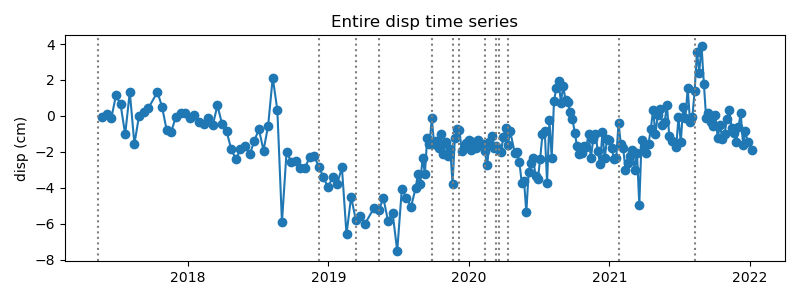

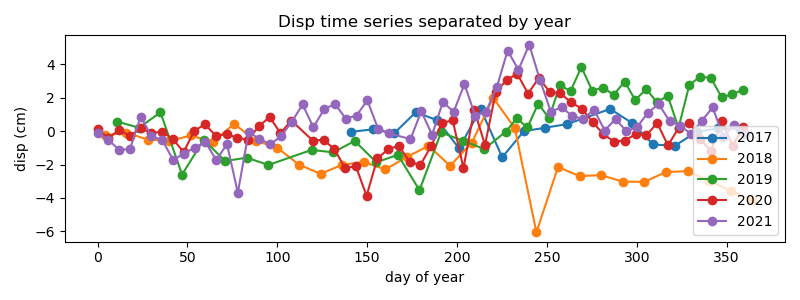

In [9]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.plot(igram_dates,ts_full,'o-')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.ylabel('disp (cm)'); plt.title('Entire disp time series')
plt.show()

plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.plot(doy_2017,ts_2017,'o-',label='2017')
plt.plot(doy_2018,ts_2018,'o-',label='2018')
plt.plot(doy_2019,ts_2019,'o-',label='2019')
plt.plot(doy_2020,ts_2020,'o-',label='2020')
plt.plot(doy_2021,ts_2021,'o-',label='2021')
plt.ylabel('disp (cm)'); plt.xlabel('day of year')
plt.legend(); plt.title('Disp time series separated by year')
plt.show()

FOR GROUP OF PIXELS: <br>
Extract time series at X by X points around the chosen point, calculate 1sigma above and below median, plot them as fill_betweens.

In [10]:
# make a series of time series at series of pixels around an area/point and do a fill_between for each 
wavelength = 5.5465763; rad2cm = wavelength/(4*np.pi)

dim_pixel_range = 10 # this is the width and height of area of pixels we are extracting data for
num_pixels = int(dim_pixel_range**2)
ts_2017_all = np.zeros((num_pixels,len(ts_2017)))
ts_2018_all = np.zeros((num_pixels,len(ts_2018)))
ts_2019_all = np.zeros((num_pixels,len(ts_2019)))
ts_2020_all = np.zeros((num_pixels,len(ts_2020)))
ts_2021_all = np.zeros((num_pixels,len(ts_2021)))

x = 1500
y = 350

# x = 2500
# y = 500

count = 0 # which pixel are we filling in data for? 
# loop through each pixel 
for j in range(dim_pixel_range):
    for k in range(dim_pixel_range):
        ts_2017_all[count,:] = np.cumsum(unwr_full_res_cor_2[0:18,y+j,x+k])*rad2cm
        ts_2018_all[count,:] = np.cumsum(unwr_full_res_cor_2[18:49,y+j,x+k])*rad2cm
        ts_2019_all[count,:] = np.cumsum(unwr_full_res_cor_2[49:89,y+j,x+k])*rad2cm
        ts_2020_all[count,:] = np.cumsum(unwr_full_res_cor_2[89:149,y+j,x+k])*rad2cm
        ts_2021_all[count,:] = np.cumsum(unwr_full_res_cor_2[149:209,y+j,x+k])*rad2cm
        count += 1
# initialize arrays 
upper_2017 = np.zeros(len(ts_2017)); lower_2017 = np.zeros(len(ts_2017)); median_2017 = np.zeros(len(ts_2017))
upper_2018 = np.zeros(len(ts_2018)); lower_2018 = np.zeros(len(ts_2018)); median_2018 = np.zeros(len(ts_2018))
upper_2019 = np.zeros(len(ts_2019)); lower_2019 = np.zeros(len(ts_2019)); median_2019 = np.zeros(len(ts_2019))
upper_2020 = np.zeros(len(ts_2020)); lower_2020 = np.zeros(len(ts_2020)); median_2020 = np.zeros(len(ts_2020))
upper_2021 = np.zeros(len(ts_2021)); lower_2021 = np.zeros(len(ts_2021)); median_2021 = np.zeros(len(ts_2021))
# find index once data is sorted to extract 1sigma above median, median, and 1sigma below median 
above_index = int(num_pixels*0.5+0.34135*num_pixels)
below_index = int(num_pixels*0.5-0.34135*num_pixels)
median_index = int(num_pixels*0.5)
# loop through ...?, sort each time series, extract the 1sigma above med value, med value, and 1sigma below med value 
for i in range(len(ts_2017)):
    temp_vals = sorted(ts_2017_all[:,i])
    upper_2017[i] = temp_vals[above_index]
    lower_2017[i] = temp_vals[below_index]
    median_2017[i] = temp_vals[median_index]
for i in range(len(ts_2018)):
    temp_vals = sorted(ts_2018_all[:,i])
    upper_2018[i] = temp_vals[above_index]
    lower_2018[i] = temp_vals[below_index]
    median_2018[i] = temp_vals[median_index]
for i in range(len(ts_2019)):
    temp_vals = sorted(ts_2019_all[:,i])
    upper_2019[i] = temp_vals[above_index]
    lower_2019[i] = temp_vals[below_index]
    median_2019[i] = temp_vals[median_index]
for i in range(len(ts_2020)):
    temp_vals = sorted(ts_2020_all[:,i])
    upper_2020[i] = temp_vals[above_index]
    lower_2020[i] = temp_vals[below_index]
    median_2020[i] = temp_vals[median_index]
for i in range(len(ts_2021)):
    temp_vals = sorted(ts_2021_all[:,i])
    upper_2021[i] = temp_vals[above_index]
    lower_2021[i] = temp_vals[below_index]
    median_2021[i] = temp_vals[median_index]

Now plot them. 

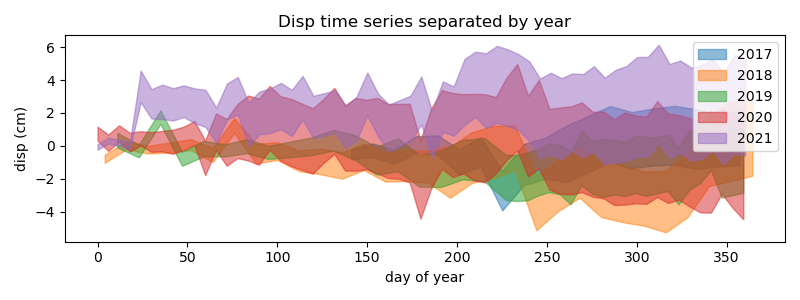

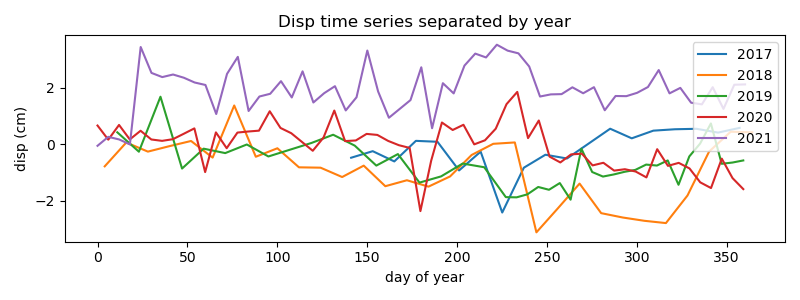

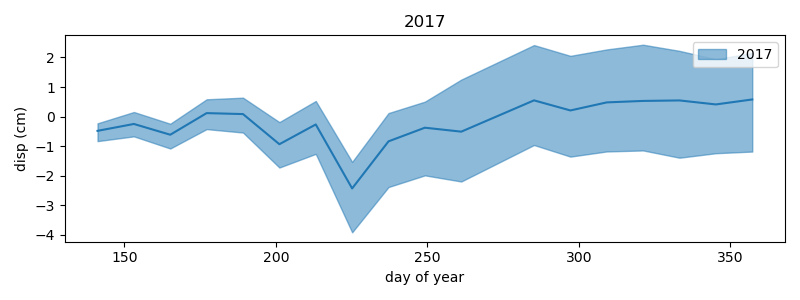

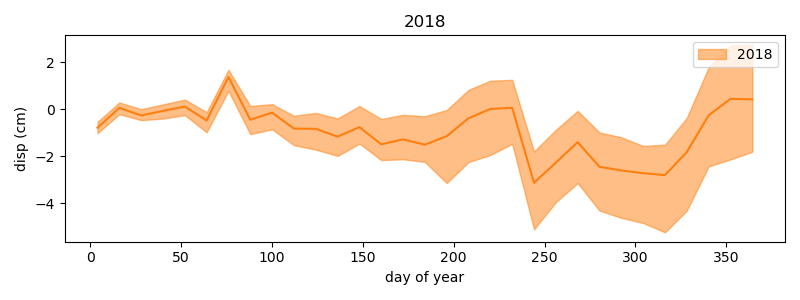

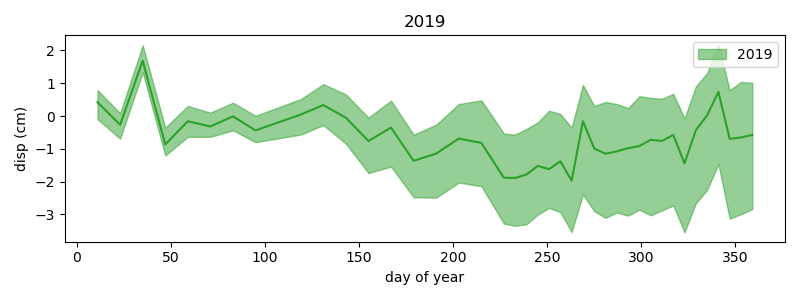

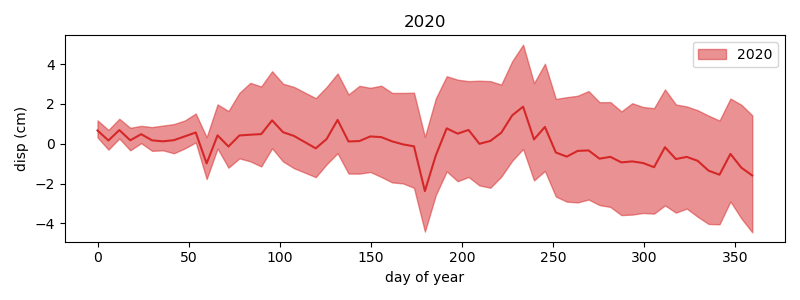

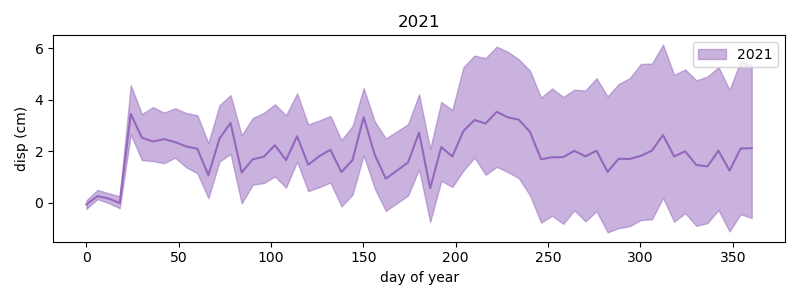

In [11]:
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2017,lower_2017,upper_2017,label='2017',alpha=0.5,color='tab:blue')
plt.fill_between(doy_2018,lower_2018,upper_2018,label='2018',alpha=0.5,color='tab:orange')
plt.fill_between(doy_2019,lower_2019,upper_2019,label='2019',alpha=0.5,color='tab:green')
plt.fill_between(doy_2020,lower_2020,upper_2020,label='2020',alpha=0.5,color='tab:red')
plt.fill_between(doy_2021,lower_2021,upper_2021,label='2021',alpha=0.5,color='tab:purple')
plt.ylabel('disp (cm)'); plt.xlabel('day of year')
plt.legend(); plt.title('Disp time series separated by year')
plt.show()

plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.plot(doy_2017,median_2017,label='2017',color='tab:blue')
plt.plot(doy_2018,median_2018,label='2018',color='tab:orange')
plt.plot(doy_2019,median_2019,label='2019',color='tab:green')
plt.plot(doy_2020,median_2020,label='2020',color='tab:red')
plt.plot(doy_2021,median_2021,label='2021',color='tab:purple')
plt.ylabel('disp (cm)'); plt.xlabel('day of year')
plt.legend(); plt.title('Disp time series separated by year')
plt.show()

plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2017,lower_2017,upper_2017,label='2017',alpha=0.5,color='tab:blue')
plt.plot(doy_2017,median_2017,color='tab:blue')
plt.ylabel('disp (cm)'); plt.xlabel('day of year'); plt.legend(); plt.title('2017'); plt.show()
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2018,lower_2018,upper_2018,label='2018',alpha=0.5,color='tab:orange')
plt.plot(doy_2018,median_2018,color='tab:orange')
plt.ylabel('disp (cm)'); plt.xlabel('day of year'); plt.legend(); plt.title('2018'); plt.show()
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2019,lower_2019,upper_2019,label='2019',alpha=0.5,color='tab:green')
plt.plot(doy_2019,median_2019,color='tab:green')
plt.ylabel('disp (cm)'); plt.xlabel('day of year'); plt.legend(); plt.title('2019'); plt.show()
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2020,lower_2020,upper_2020,label='2020',alpha=0.5,color='tab:red')
plt.plot(doy_2020,median_2020,color='tab:red')
plt.ylabel('disp (cm)'); plt.xlabel('day of year'); plt.legend(); plt.title('2020'); plt.show()
plt.figure(figsize=(8,3),tight_layout='TRUE')
plt.fill_between(doy_2021,lower_2021,upper_2021,label='2021',alpha=0.5,color='tab:purple')
plt.plot(doy_2021,median_2021,color='tab:purple')
plt.ylabel('disp (cm)'); plt.xlabel('day of year'); plt.legend(); plt.title('2021'); plt.show()

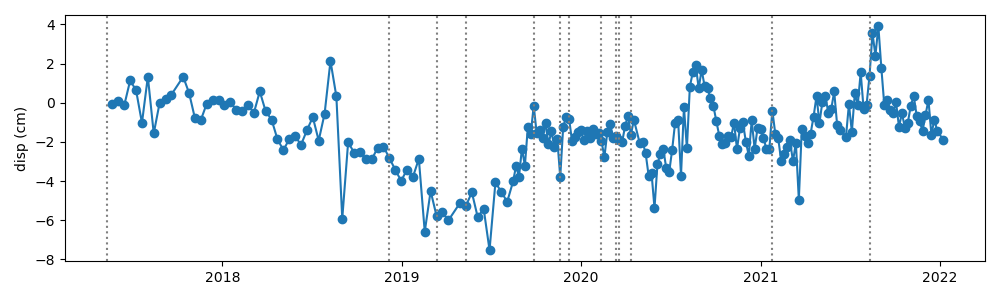

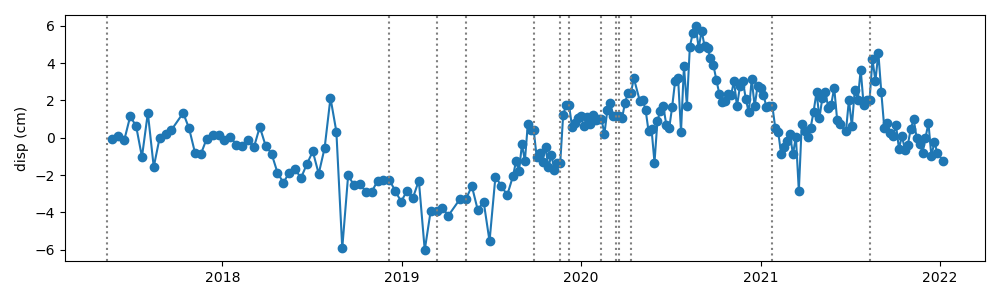

In [12]:
# for a full time series at a point, remove points where coherence < threshold value (rain dates), set equal to zero. 
# then, calculate how much uplift/subsidence on rain dates would have to compensate to end up with zero disp 

ts_rates[rain_indices] = 0
ts_full_zeroed = np.cumsum(ts_rates)*rad2cm


plt.figure(figsize=(10,3),tight_layout='TRUE')
plt.plot(igram_dates,ts_full,'o-')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.ylabel('disp (cm)')
plt.show()

plt.figure(figsize=(10,3),tight_layout='TRUE')
plt.plot(igram_dates,ts_full_zeroed,'o-')
Ymin,Ymax = plt.gca().get_ylim()
plt.vlines(rain_dates,Ymin,Ymax,'gray',':',zorder=5)
plt.ylim([Ymin,Ymax])
plt.ylabel('disp (cm)')
plt.show()